In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize

from functools import partial
import itertools
import re

import matplotlib.gridspec as gridspec
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pylab as pl
import scipy as sp
from graphviz import Digraph
import pydot
from IPython.display import Image
import pandas as pd
import seaborn as sns

print(__doc__)
import pandas as pd
from patsy import dmatrices
import scipy as sc
import scipy.optimize as opt
import statsmodels.api as sm

import sklearn as sk


from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import TransformerMixin
from sklearn.pipeline import BaseEstimator
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.utils.metaestimators import if_delegate_has_method
from sklearn.utils import column_or_1d
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union


from sklearn.datasets import samples_generator
from sklearn import datasets

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

from sklearn.feature_extraction import DictVectorizer

import sklearn.feature_extraction as fe

import sklearn.feature_selection as fs
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold

import sklearn.linear_model as lm
import sklearn.grid_search as gs
from sklearn.svm import SVC
from sklearn.decomposition import PCA


import sklearn.preprocessing as preprocessing
import sklearn.cross_validation as cv
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc

from sklearn_pandas import DataFrameMapper, cross_val_score

import matplotlib.pyplot as plt
import patsy
from statsmodels.sandbox import cox

from patsylearn import *

import joblib as jb


from datasu.auc import *
from datasu.dicts import *
from datasu.files import *
from datasu.pandas import *
from datasu.persist import *

Automatically created module for IPython interactive environment


/root/.pyenv/versions/2.7.9/envs/2.7.9-analytics2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## UTILS

In [2]:
def plot_auc(y_score, y_true):
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_score, y_true)

    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % (roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
from sklearn.cross_validation import StratifiedKFold
from sklearn import svm
from scipy import interp

def run_crossval(X,y, fitter):
    
    # Classification and ROC analysis

    # Run classifier with cross-validation and plot ROC curves
    skf_cv = StratifiedKFold(y, n_folds=5) #n_folds=6
#     classifier = svm.Lo(kernel='linear', probability=True,random_state=random_state)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(skf_cv):
        model = fitter.fit(X.iloc[train], y.iloc[train])
#         probas_ = model.predict_proba(X.iloc[test])        
#         fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        probas_ = model.decision_function(X.iloc[test])        
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(skf_cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return mean_auc

## LOAD DATA

In [4]:
main_folder = '/ea/Datasets/Kaggle-AcquireValuedShoppersChallenge2/'
df_coupons = pd.read_csv(main_folder+'offers')[['offer','category','company','brand','offervalue','quantity']]
df_offers_ids = pd.read_csv(main_folder+'trainHistory').rename(columns={'id': 'customer_id'})
df_offers_ids_submission = pd.read_csv(main_folder+'testHistory').rename(columns={'id': 'customer_id'})
# df_trans_all = pd.read_csv(main_folder+'transactions_reduced_category').rename(columns={'id': 'customer_id'})

In [5]:
df_offers_all = pd.merge(df_offers_ids, df_coupons, on=['offer'])
df_offers_all = df_offers_all[['customer_id','chain','offer','market','category','company','brand','offerdate','offervalue','quantity','repeattrips','repeater']]

df_offers_all_submission = pd.merge(df_offers_ids_submission, df_coupons, on=['offer'])
df_offers_all_submission = df_offers_all_submission[['customer_id','chain','offer','market','category','company','brand','offerdate','offervalue','quantity']]

In [6]:
df_coupons.head()

,offer,category,company,brand,offervalue,quantity
0,1190530,9115,108500080,93904,5.00,1
1,1194044,9909,107127979,6732,1.00,1
2,1197502,3203,106414464,13474,0.75,1
3,1198271,5558,107120272,5072,1.50,1
4,1198272,5558,107120272,5072,1.50,1


In [7]:
df_coupons[df_coupons.offer==1213242]

,offer,category,company,brand,offervalue,quantity
26,1213242,5824,105190050,26456,2,1


In [74]:
df_offers_all.head()
len(df_)

160057

In [9]:
df_trans_all.head()

NameError: name 'df_trans_all' is not defined

/root/.pyenv/versions/2.7.9/envs/2.7.9-analytics2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':
/root/.pyenv/versions/2.7.9/envs/2.7.9-analytics2/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


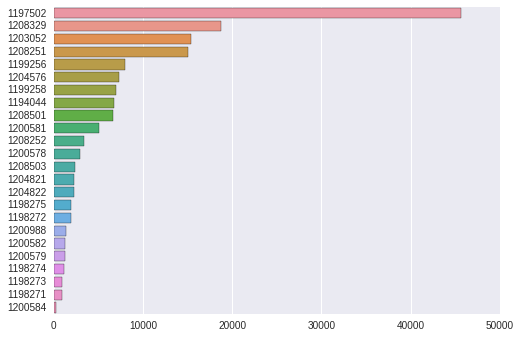

In [10]:
offer_counts = df_offers_all.groupby(by='offer').count().customer_id.order(ascending=False)
sns.barplot(y=offer_counts.index.values, x=offer_counts.values, orient='h')

In [11]:
df_offers_all.head()

,customer_id,chain,offer,market,category,company,brand,offerdate,offervalue,quantity,repeattrips,repeater
0,86246,205,1208251,34,2202,104460040,3718,2013-04-24,2,1,5,t
1,15753725,17,1208251,4,2202,104460040,3718,2013-04-24,2,1,0,f
2,16535563,4,1208251,1,2202,104460040,3718,2013-04-27,2,1,7,t
3,18259179,3,1208251,2,2202,104460040,3718,2013-04-24,2,1,0,f
4,21024070,15,1208251,9,2202,104460040,3718,2013-04-23,2,1,1,t


In [12]:
customer_counts = df_offers_all.groupby(by='customer_id').count().offer.order(ascending=False)
# sns.barplot(y=customer_counts.index.values, x=customer_counts.values, orient='h')

/root/.pyenv/versions/2.7.9/envs/2.7.9-analytics2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


## FILTER DATA

In [13]:
df_trans = df_trans_all#[0:3000000]

NameError: name 'df_trans_all' is not defined

In [14]:
df_offers_filtered = df_offers_all#[df_offers_all.offer==1197502]

In [15]:
len(df_trans.customer_id.unique()), len(df_trans.customer_id),  len(df_offers_filtered.customer_id.unique()),len(df_offers_filtered.customer_id), 

NameError: name 'df_trans' is not defined

### LOAD FEATURES FROM DISK

In [16]:
load_variables(path=main_folder+'working_data');

['df_trans_grp_customer_brand.var', 'df_trans_grp_customer_category.var', 'df_trans_grp_customer_dept.var']
loaded df_trans_grp_customer_brand
loaded df_trans_grp_customer_category
loaded df_trans_grp_customer_dept


### MERGE FEATURES TO ONE TABLE

In [17]:
print len(df_offers_all)
df_offers_all.head()

160057


,customer_id,chain,offer,market,category,company,brand,offerdate,offervalue,quantity,repeattrips,repeater
0,86246,205,1208251,34,2202,104460040,3718,2013-04-24,2,1,5,t
1,15753725,17,1208251,4,2202,104460040,3718,2013-04-24,2,1,0,f
2,16535563,4,1208251,1,2202,104460040,3718,2013-04-27,2,1,7,t
3,18259179,3,1208251,2,2202,104460040,3718,2013-04-24,2,1,0,f
4,21024070,15,1208251,9,2202,104460040,3718,2013-04-23,2,1,1,t


In [75]:
df_offers_all_merge4 = merge_data(df_offers_all, how='left',
                                  rights=[(df_trans_grp_customer_brand,['customer_id','brand']),
                                          (df_trans_grp_customer_category,['customer_id', 'category']),
#                                           (df_trans_grp_customer_dept,['customer_id'])
                                         ])

df_offers_all_merge4.fillna(0, inplace=True)
df_offers_all_merge4.head()

160057
160057
160057


,customer_id,chain,offer,market,category,company,brand,offerdate,offervalue,quantity,...,agg_purchaseamount_customer_id_brand_total,agg_purchasequantity_customer_id_brand_average,agg_purchasequantity_customer_id_brand_total,agg_productsize_customer_id_category_total,agg_productsize_customer_id_category_average,agg_customer_id_customer_id_category_count,agg_purchaseamount_customer_id_category_total,agg_purchaseamount_customer_id_category_average,agg_purchasequantity_customer_id_category_total,agg_purchasequantity_customer_id_category_average
0,86246,205,1208251,34,2202,104460040,3718,2013-04-24,2,1,...,5.69,1,1,0,0,0,0,0,0,0
1,15753725,17,1208251,4,2202,104460040,3718,2013-04-24,2,1,...,0.00,0,0,0,0,0,0,0,0,0
2,16535563,4,1208251,1,2202,104460040,3718,2013-04-27,2,1,...,0.00,0,0,0,0,0,0,0,0,0
3,18259179,3,1208251,2,2202,104460040,3718,2013-04-24,2,1,...,0.00,0,0,0,0,0,0,0,0,0
4,21024070,15,1208251,9,2202,104460040,3718,2013-04-23,2,1,...,0.00,0,0,0,0,0,0,0,0,0


In [19]:
len(df_offers_all), len(df_offers_all_merge4), len(df_offers_all_merge4.columns)

(160057, 160057, 26)

In [20]:
df_offers_all_merge4.brand.unique()

array([  3718,  13474, 102504,   7668,  15889,    875,  13791,   5072,
         6926,  64486,  28840,   6732])

### CLEAR MEMORY

In [21]:
# %reset_selective -f df_trans_all
# %reset_selective -f df_trans

## TRAIN MODEL

In [22]:
df_data_train = df_offers_all_merge4

In [23]:
df_data_train.columns

Index([u'customer_id', u'chain', u'offer', u'market', u'category', u'company',
       u'brand', u'offerdate', u'offervalue', u'quantity', u'repeattrips',
       u'repeater', u'agg_productsize_customer_id_brand_average',
       u'agg_productsize_customer_id_brand_total',
       u'agg_customer_id_customer_id_brand_count',
       u'agg_purchaseamount_customer_id_brand_average',
       u'agg_purchaseamount_customer_id_brand_total',
       u'agg_purchasequantity_customer_id_brand_average',
       u'agg_purchasequantity_customer_id_brand_total',
       u'agg_productsize_customer_id_category_total',
       u'agg_productsize_customer_id_category_average',
       u'agg_customer_id_customer_id_category_count',
       u'agg_purchaseamount_customer_id_category_total',
       u'agg_purchaseamount_customer_id_category_average',
       u'agg_purchasequantity_customer_id_category_total',
       u'agg_purchasequantity_customer_id_category_average'],
      dtype='object')

In [24]:
df_data_train.repeattrips.sum()

105051

In [25]:
categorical_cols = ['chain','market','category','company','brand']
agg_cols = filter(lambda c: re.match("agg_*",c), df_data_train.columns)
num_cols = ['offervalue','quantity']


In [26]:
df_X = df_data_train.filter(items=categorical_cols+agg_cols+num_cols) 
columns_to_type(df_X, categorical_cols, 'category')

df_Y = df_data_train[['repeater']]
Y = df_Y.repeater.map(lambda v: v=='t')
W = df_data_train.repeattrips.replace(to_replace=0, value=1).values

In [27]:
categorical_cols

['chain', 'market', 'category', 'company', 'brand']

In [28]:
df_X.columns

Index([u'chain', u'market', u'category', u'company', u'brand',
       u'agg_productsize_customer_id_brand_average',
       u'agg_productsize_customer_id_brand_total',
       u'agg_customer_id_customer_id_brand_count',
       u'agg_purchaseamount_customer_id_brand_average',
       u'agg_purchaseamount_customer_id_brand_total',
       u'agg_purchasequantity_customer_id_brand_average',
       u'agg_purchasequantity_customer_id_brand_total',
       u'agg_productsize_customer_id_category_total',
       u'agg_productsize_customer_id_category_average',
       u'agg_customer_id_customer_id_category_count',
       u'agg_purchaseamount_customer_id_category_total',
       u'agg_purchaseamount_customer_id_category_average',
       u'agg_purchasequantity_customer_id_category_total',
       u'agg_purchasequantity_customer_id_category_average', u'offervalue',
       u'quantity'],
      dtype='object')

In [29]:
print len(categorical_cols+agg_cols), len(df_X.columns)
print len(df_X),len(df_Y)

19 21
160057 160057


### BUILD PIPELINE

In [30]:
mapper = DataFrameMapper([
        (col, sk.preprocessing.LabelBinarizer()) for col in categorical_cols] 
      + [(agg_cols+num_cols, None)])

prepare_pipeline = make_pipeline(mapper,
                        PolynomialFeatures(degree=1, interaction_only=True),                         
                        preprocessing.StandardScaler()
                        ) 

In [31]:
fit_pipeline_LR1 = make_pipeline(prepare_pipeline,
                             lm.LogisticRegression(C=0.001, penalty='l1'))     
# class_weight=W_train

### SPLIT TRAIN-TEST

In [32]:
df_X_train, df_X_test, Y_train, Y_test, W_train, W_test = train_test_split(df_X, Y, W)
len(df_X_train),len(df_X_test)


(120042, 40015)

### FIT MODEL

In [33]:
fit_pipeline_LR1.fit(df_X_train, y=Y_train)
print 'score in-sample: ' + str(fit_pipeline_LR1.score(df_X_train, y=Y_train))

score in-sample: 0.746930241082


In [34]:
logreg = fit_pipeline_LR1.named_steps['logisticregression']
logreg.classes_
sum(logreg.coef_[0,:])

0.69223931269532968

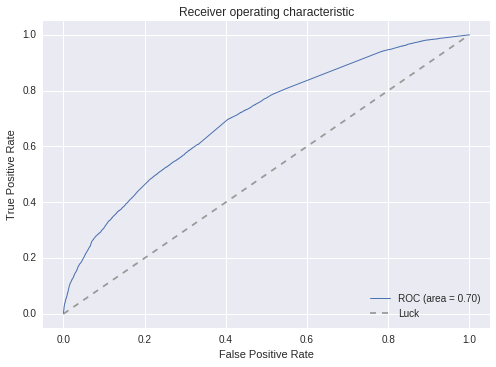

In [35]:
plot_auc(Y_test, fit_pipeline_LR1.decision_function(df_X_test))

### CROSSVALIDATION

In [76]:
scores = cv.cross_val_score(fit_pipeline_LR1, df_X, Y,cv=5, scoring='accuracy')
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# X_test = prepare_pipeline.transform(X_test)
# print 'Test accuracy: %0.2f' % fit_pipeline.score(X_test, Y_test


[ 0.726009    0.72885168  0.30929027  0.47655493  0.41471415]
Accuracy: 0.53 (+/- 0.34)


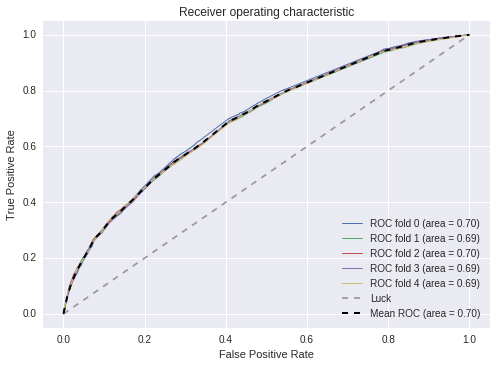

0.6961909903636686

In [77]:
run_crossval(df_X_train, Y_train, fit_pipeline_LR1)

## TEST ON KAGGLE

### FIT MODEL ON ALL DATA

In [38]:
fit_pipeline_LR1.fit(df_X_train, y=Y_train)
print 'score in-sample: ' + str(fit_pipeline_LR1.score(df_X_train, y=Y_train))

score in-sample: 0.746930241082


### PREPARA DATA FOR PREDICTION

In [39]:
df_offers_all_submission.head()

,customer_id,chain,offer,market,category,company,brand,offerdate,offervalue,quantity
0,12262064,95,1219903,39,799,1076211171,17286,2013-06-27,1.5,1
1,15575309,17,1219903,4,799,1076211171,17286,2013-07-05,1.5,1
2,18985721,4,1219903,1,799,1076211171,17286,2013-07-15,1.5,1
3,20552767,14,1219903,8,799,1076211171,17286,2013-06-29,1.5,1
4,21323129,4,1219903,1,799,1076211171,17286,2013-06-28,1.5,1


In [40]:
df_offers_all_submission_merge4 = merge_data(df_offers_all_submission, how='left',
                                             rights=[(df_trans_grp_customer_brand,['customer_id','brand']),
                                                     (df_trans_grp_customer_category,['customer_id', 'category']),
#                                                      (df_trans_grp_customer_dept,['customer_id'])
                                                    ])
df_offers_all_submission_merge4.fillna(0, inplace=True)

151484
151484
151484


In [41]:
len(df_offers_all_submission_merge4), len(df_offers_all_submission.customer_id.unique())

(151484, 151484)

In [42]:
df_offers_all_submission_merge4[df_offers_all_submission_merge4.customer_id==12262064]

,customer_id,chain,offer,market,category,company,brand,offerdate,offervalue,quantity,...,agg_purchaseamount_customer_id_brand_total,agg_purchasequantity_customer_id_brand_average,agg_purchasequantity_customer_id_brand_total,agg_productsize_customer_id_category_total,agg_productsize_customer_id_category_average,agg_customer_id_customer_id_category_count,agg_purchaseamount_customer_id_category_total,agg_purchaseamount_customer_id_category_average,agg_purchasequantity_customer_id_category_total,agg_purchasequantity_customer_id_category_average
0,12262064,95,1219903,39,799,1076211171,17286,2013-06-27,1.5,1,...,6.79,1.5,3,0,0,0,0,0,0,0


In [43]:
df_X_submission = df_offers_all_submission_merge4.filter(items=categorical_cols+agg_cols+num_cols) 
columns_to_type(df_X_submission, categorical_cols, 'category')


In [44]:
df_X_submission.columns

Index([u'chain', u'market', u'category', u'company', u'brand',
       u'agg_productsize_customer_id_brand_average',
       u'agg_productsize_customer_id_brand_total',
       u'agg_customer_id_customer_id_brand_count',
       u'agg_purchaseamount_customer_id_brand_average',
       u'agg_purchaseamount_customer_id_brand_total',
       u'agg_purchasequantity_customer_id_brand_average',
       u'agg_purchasequantity_customer_id_brand_total',
       u'agg_productsize_customer_id_category_total',
       u'agg_productsize_customer_id_category_average',
       u'agg_customer_id_customer_id_category_count',
       u'agg_purchaseamount_customer_id_category_total',
       u'agg_purchaseamount_customer_id_category_average',
       u'agg_purchasequantity_customer_id_category_total',
       u'agg_purchasequantity_customer_id_category_average', u'offervalue',
       u'quantity'],
      dtype='object')

In [45]:
probas_ = fit_pipeline_LR1.decision_function(df_X_submission).astype(float)

In [46]:
len(probas_)
probas_

array([-0.93913396, -0.85060607, -0.91861917, ..., -1.25590353,
       -1.64677712, -1.69945429])

In [47]:
sum(probas_),sum(probas_)

(-172658.28397758404, -172658.28397758404)

In [48]:
df_submission = df_offers_all_submission.customer_id.to_frame(name='id')
df_submission['repeatProbability'] = probas_.tolist()
df_submission.head()

,id,repeatProbability
0,12262064,-0.939134
1,15575309,-0.850606
2,18985721,-0.918619
3,20552767,-1.030491
4,21323129,-0.910770


In [49]:
df_submission.to_csv(path_or_buf=main_folder+'submission13_LR1', index=False)

## NEXT BEST ACTION

In [62]:
df_offers_ids_100 = df_offers_ids[0:100]

In [63]:
def repeat_for_items(df, items_column, items=None, inplace=False):
    
    if items is None:
        items = df[items_column].unique()
                
    items_series = pd.Series([items]*len(df), index=df.index, name='items_array')
    
    if inplace == False:
        df = df.copy()
    
    df[items_column] = items_series
    
    df_explode = explode_column(df, items_column)

    return df_explode

In [64]:
def explode_column(df, explode_column):
    
    df_items_explode = pd.concat([pd.DataFrame(v, index=np.repeat(k,len(v)), columns=['explode_column']) for k,v in df[explode_column].to_dict().items()])
    
    df_explode = df_items_explode.join(df)
    df_explode.rename(columns={explode_column: 'old_item_column','explode_column':explode_column}, inplace=True)
    df_explode.drop(['old_item_column'], axis=1, inplace=True)
    
    return df_explode

In [65]:
len(repeat_for_items(df_offers_ids_100, 'offer'))

800

In [66]:
df_offers_ids_100_explode = repeat_for_items(df_offers_ids_100, 'offer', df_coupons.offer.unique())
df_offers_ids_100_explode.head()

,offer,customer_id,chain,market,repeattrips,repeater,offerdate
0,1190530,86246,205,34,5,t,2013-04-24
0,1194044,86246,205,34,5,t,2013-04-24
0,1197502,86246,205,34,5,t,2013-04-24
0,1198271,86246,205,34,5,t,2013-04-24
0,1198272,86246,205,34,5,t,2013-04-24


In [67]:
df_offers_all_100_explode = pd.merge(df_offers_ids_100_explode, df_coupons, on=['offer'])
df_offers_all_100_explode = df_offers_all_100_explode[['customer_id','chain','offer','market','category','company','brand','offerdate','offervalue','quantity']]

df_offers_all_100_explode.head()

,customer_id,chain,offer,market,category,company,brand,offerdate,offervalue,quantity
0,86246,205,1190530,34,9115,108500080,93904,2013-04-24,5,1
1,86252,205,1190530,34,9115,108500080,93904,2013-03-27,5,1
2,12682470,18,1190530,11,9115,108500080,93904,2013-03-28,5,1
3,12996040,15,1190530,9,9115,108500080,93904,2013-03-25,5,1
4,13089312,15,1190530,9,9115,108500080,93904,2013-04-01,5,1


In [68]:
df_offers_all_100_explode_merge4 = merge_data(df_offers_all_100_explode, how='left',
                                             rights=[(df_trans_grp_customer_brand,['customer_id','brand']),
                                                     (df_trans_grp_customer_category,['customer_id', 'category']),
#                                                      (df_trans_grp_customer_dept,['customer_id'])
                                                    ])
df_offers_all_100_explode_merge4.fillna(0, inplace=True)

3700
3700
3700


In [69]:
df_X_all_100_explode = df_offers_all_100_explode_merge4.filter(items=categorical_cols+agg_cols+num_cols) 
columns_to_type(df_X_all_100_explode, categorical_cols, 'category')

In [72]:
df_offers_all_100_explode['proba'] = fit_pipeline_LR1.predict_proba(df_X_all_100_explode).astype(float)[:,0]
df_offers_all_100_explode = df_offers_all_100_explode.sort_values(by=['customer_id', 'offer'], ascending=True)

df_offers_all_100_explode.head()

,customer_id,chain,offer,market,category,company,brand,offerdate,offervalue,quantity,proba
0,86246,205,1190530,34,9115,108500080,93904,2013-04-24,5.00,1,0.783672
100,86246,205,1194044,34,9909,107127979,6732,2013-04-24,1.00,1,0.381605
200,86246,205,1197502,34,3203,106414464,13474,2013-04-24,0.75,1,0.731086
300,86246,205,1198271,34,5558,107120272,5072,2013-04-24,1.50,1,0.692219
400,86246,205,1198272,34,5558,107120272,5072,2013-04-24,1.50,1,0.692219


In [73]:
df_offers_100_NBA = df_offers_all_100_explode.sort_values(by=['proba'], ascending=False).groupby(by=['customer_id']).first()
df_offers_100_NBA.head()

,chain,offer,market,category,company,brand,offerdate,offervalue,quantity,proba
customer_id,,,,,,,,,,
86246,205,1200578,34,1703,104460040,7668,2013-04-24,1.5,1,0.853835
86252,205,1200579,34,1703,104460040,7668,2013-03-27,1.5,1,0.856334
12682470,18,1199258,11,4401,105100050,13791,2013-03-28,2.0,1,0.892173
12996040,15,1199256,9,4401,105100050,13791,2013-03-25,2.0,1,0.892173
13089312,15,1199256,9,4401,105100050,13791,2013-04-01,2.0,1,0.892173


## OTHER

In [ ]:
X =patsy.dmatrix('productsize_id_category_total:C(category, Treatment)  -1', data=df_trans_category_grp, return_type='dataframe')
X.head()

In [ ]:
X = patsy.dmatrix('market + category -1', data=df_off_hist_train, return_type='dataframe')
X.head()

In [ ]:
pd.DataFrame(df_trans_grp_brand.to_records())

In [ ]:
X = patsy.dmatrix('total_int_calls_minutes:C(intl_package, Treatment) + age -1', data=X_train, return_type='dataframe')

In [ ]:
df_offers_history[df_offers_history.id==4638754711]

In [ ]:
df_off_hist_train['id_chain'] =  df_off_hist_train['id'].map(lambda x:(str(x)+'_')) + df_off_hist_train['chain'].map(str)

# PREPARE FILES

In [ ]:
from datetime import datetime
import zipfile

loc_history = "./testHistory"

loc_transactions = "./transactions"
loc_reduced = "./transactions_reduced_customer_test" # will be created




In [ ]:
reduce_data(loc_history, loc_transactions, loc_reduced)
